### Ploting buckets after training

In [1]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
from annoy import AnnoyIndex
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import seaborn as sns

from keras.layers import Concatenate, Add, Lambda, merge, Average

%matplotlib inline

Using TensorFlow backend.


In [2]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [3]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [4]:
# Domain to use
DOMAIN = 'eclipse'
'''
    deepQL_topics_
    deepTL_
    baseline_
'''
METHOD = 'baseline_'
EMBEDDING_METHOD = 'keras'
PREPROCESSING = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Save model
SAVE_PATH = '{}@number_of_epochs@_feature@number_of_epochs@epochs_64batch({})'.format(METHOD, DOMAIN)
SAVE_PATH_FEATURE_1_EPOCH = '{}_preprocessing_{}1_feature_1epochs_64batch({})'.format(PREPROCESSING, METHOD,  DOMAIN)
SAVE_PATH_FEATURE = '{}_preprocessing_{}@number_of_epochs@_feature_@number_of_epochs@epochs_64batch({})'.format(PREPROCESSING, METHOD, DOMAIN)

# Extract CORPUs
EXTRACT_CORPUS = False

In [5]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [6]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [7]:
"Total vocabulary: {}".format(len(token_dict))

'Total vocabulary: 30522'

In [8]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [9]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [10]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


361006

In [11]:
%%time

experiment.load_bugs()
len(baseline.sentence_dict)


CPU times: user 1min 6s, sys: 4.76 s, total: 1min 11s
Wall time: 1min 17s


In [12]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [13]:
%%time

experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')
# Read and create the test queries duplicates
experiment.set_retrieval(retrieval, baseline, DOMAIN)

CPU times: user 5.17 s, sys: 76.3 ms, total: 5.25 s
Wall time: 5.49 s


In [14]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [15]:
from sklearn.manifold import TSNE
import random

def plot_2d(test_labels, tsne_features, categories, colors=None, name=''):
    test_labels = np.asarray(test_labels)
#     test_labels = np.sort(test_labels)
    if colors is None:
        colors = [(random.uniform(.25, .75), random.uniform(.5, .75), random.uniform(.5, .75)) for i in enumerate(test_labels)]
    plt.figure(figsize=(10, 10))
    categories = np.asarray(categories)
    ind = categories.argsort()[::-1]
    categories = categories[ind]
    for c_color, c_label in zip(colors, categories):
        plt.scatter(tsne_features[np.where(test_labels == c_label), 0],
                    tsne_features[np.where(test_labels == c_label), 1],
                    marker='o',
                    color=c_color,
                    linewidth='1',
                    alpha=0.9,
                    label=c_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE on Buckets')
    plt.legend(categories, loc='upper center', bbox_to_anchor=(0.5, -0.05), prop={'size': 22})
    plt.savefig('resultados/{}.png'.format(name), bbox_inches="tight")
    plt.show(block=False)
    if colors is not None:
        return colors

def create_features(x_test_features):
#     tsne_obj = TSNE(n_components=2,
#                             init='pca',
#                             random_state=101,
#                             method='barnes_hut',
#                             n_iter=500,
#                             verbose=0)
    tsne_obj = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_features = tsne_obj.fit_transform(x_test_features)
    return tsne_features

### Model 1000

In [16]:
'modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5'

'modelos/model_bert_preprocessing_baseline_1000_feature_1000epochs_64batch(eclipse).h5'

In [17]:
import os
from keras.models import load_model
import keras.backend as K
from keras_bert import get_custom_objects

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = load_model('modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Model 1

In [18]:
'modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5'

'modelos/model_bert_preprocessing_baseline_1_feature_1epochs_64batch(eclipse).h5'

In [19]:
model_1_epoch = load_model('modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
buckets_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 2]
buckets_biggest_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 2]
buckets_3_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 3]
buckets_5_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 5]
buckets_between_5_and_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 5 and len(retrieval.buckets[bucket]) <= 10]
buckets_biggest_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 10]

In [21]:
len(buckets_biggest_2_dups), len(buckets_2_dups), len(buckets_3_dups), len(buckets_5_dups), len(buckets_between_5_and_10_dups), len(buckets_biggest_10_dups)

(28834, 35102, 11592, 3185, 5683, 2850)

In [22]:
import numpy as np
from keras import layers

def create_tsne_vector(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    bucket_labels = set()
    
    config = model.get_config()
    if method == 'keras':
        max_vocab = config['layers'][4]['config']['layers'][1]['config']['input_dim']
    if method == 'dwen':
        max_vocab = 1

    for row  in bucket_dups_selected:
        bug_id, bucket_id = row
        # bucket and dups
        if bug_id not in baseline.bug_set: continue
        if bug_id in retrieval.buckets:
            label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(label)
            bucket_labels.add(label)
        else:
            dup_label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(dup_label)
            bucket_labels.add(dup_label)
        bug = baseline.bug_set[bug_id]
        
        if method == 'keras' or method == 'dwen':
            title_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['title_token']])
        else:
            title_data.append(bug['title_token'])
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        
        if method == 'keras' or method == 'dwen':
            desc_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['description_token']])
        else:
            desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        info_data.append(experiment.retrieval.get_info(bug))
        if('topics' in bug):
            topic_data.append(bug['topics'])
    bucket_labels = list(bucket_labels)
    
    if method == 'keras':
        test_features = model.predict([ np.array(title_data), np.array(desc_data), np.array(info_data) ])
    if method == 'bert':
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data) ])
    elif method == 'bert-topic':
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data), np.array(topic_data) ])
    elif method == 'dwen':
        test_features = model.predict([ np.array(title_data), np.array(desc_data) ])
    
    return bucket_labels, test_features, categories

### Select random buckets

In [23]:
# selected_buckets = [ 47708, 228156, 132573, 132662, 207563]
# [226761, 211165,  60740, 172436, 160273]
# [146677, 118038, 207060, 236101,  35870] - best
# [ 47708, 228156, 132573, 132662, 207563] - best
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)
if(DOMAIN == 'openoffice'):
    # [119525, 1601, 37793, 103839, 16268]
    # [  8695,  16832,  56298,  57154, 122962]
    # [14818, 63708,  7182,  9966,  5767] bad to DeepTL
    # [89649, 5684,  28471,  19477,  100934] good for DeepQL_topics
    selected_buckets = [89649, 5684,  28471,  19477,  100934]
elif(DOMAIN == 'netbeans'):
    selected_buckets = [158328, 73960, 14803, 212061, 123467]
elif(DOMAIN == 'eclipse'):
    # [33419, 31790, 63825, 35846, 19128]
    # [ 49170,  45216,  42804,   9509, 116401] bad to DeepTL and DeepQL
    # good to DeepQL
    # [157282,  66298,  44798, 301724,  99245]
    # bad to DeepTl
    # [240875,  23302, 127290,  94029, 108976]
    # good to deepTL
    # [106159, 211868, 293881, 164259,  22883] 
    # [360214, 186520, 114434, 111044, 398480]
    selected_buckets = [240875,  23302, 127290,  94029, 108976]

In [24]:
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)

In [25]:
DOMAIN

'eclipse'

In [26]:
selected_buckets

[240875, 23302, 127290, 94029, 108976]

### Eclipse
#### [ 34940,   6749, 264112,  19771,  63692]

### NetBeans
#### [158328,  73960,  14803, 212061, 123467]

### Open Office

##### [119525,   1601,  37793, 103839,  16268]

In [27]:
selected_buckets

[240875, 23302, 127290, 94029, 108976]

In [28]:
bucket_dups_selected = []
for bucket in selected_buckets:
    bucket_dups_selected += [(bug_id, bucket) for bug_id in retrieval.buckets[bucket]]

### Model trained with 1 epoch

In [29]:
bucket_labels_1epoch, test_features_1epoch, categories_1epoch = create_tsne_vector(model_1_epoch, method=EMBEDDING_METHOD)

### Select random buckets

In [30]:
bucket_labels, test_features, categories = create_tsne_vector(model, method=EMBEDDING_METHOD)

### Visualizing bucket space

Plota um conjunto de duplicados pintando o mestre de uma cor e os seus duplicados de outra

In [31]:
# colors = [(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.99, 0.9, 0), (0.9, 0.4, 0)]
colors = sns.color_palette("Set1", n_colors=len(selected_buckets)) 

### 1 epoch

In [32]:
bucket_labels_1epoch

['duplicate_of_94029',
 'duplicate_of_23302',
 'duplicate_of_240875',
 'duplicate_of_108976',
 'duplicate_of_127290']

In [33]:
test_features_1epoch.shape, len(categories_1epoch), len(bucket_labels_1epoch)

((82, 900), 82, 5)

[t-SNE] Computing 81 nearest neighbors...
[t-SNE] Indexed 82 samples in 0.000s...
[t-SNE] Computed neighbors for 82 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 82 / 82
[t-SNE] Mean sigma: 1.008167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.851749
[t-SNE] Error after 300 iterations: 0.666887


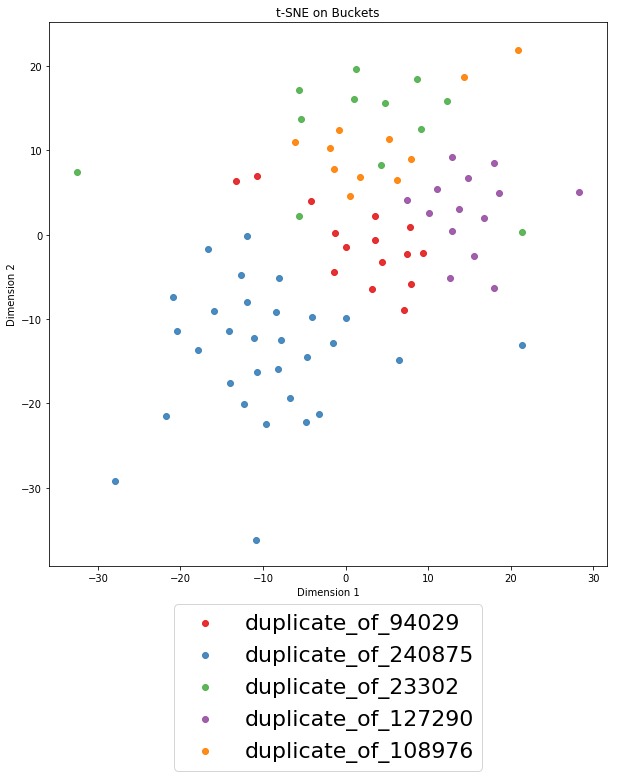

In [34]:
tsne_features_1epoch = create_features(test_features_1epoch)

colors = plot_2d(categories_1epoch, tsne_features_1epoch, bucket_labels_1epoch, colors=colors, name='buckets_{}_{}1_epoch.png'.format(DOMAIN, METHOD))

### 1000 epochs

In [35]:
test_features.shape, len(categories), len(bucket_labels)

((82, 900), 82, 5)

[t-SNE] Computing 81 nearest neighbors...
[t-SNE] Indexed 82 samples in 0.000s...
[t-SNE] Computed neighbors for 82 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 82 / 82
[t-SNE] Mean sigma: 2.789657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.836201
[t-SNE] Error after 300 iterations: 0.660059


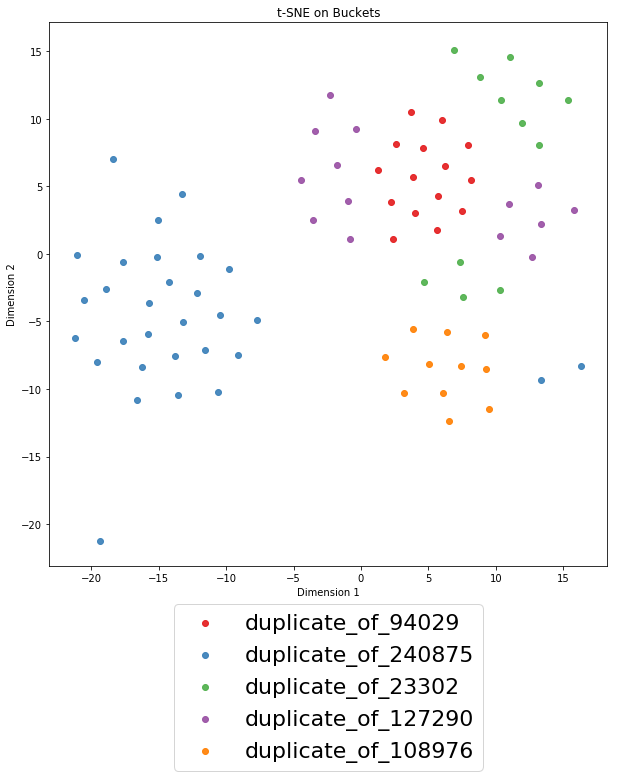

In [36]:
tsne_features = create_features(test_features)

_ = plot_2d(categories, tsne_features, bucket_labels, colors=colors, name='buckets_{}_{}1000_epoch.png'.format(DOMAIN, METHOD))

## Topic latent space

In [37]:
if('deepQL_topics' in METHOD):
    topic_size = K.int_shape(model_1_epoch.get_layer('topics_in').output)[1]
    print("Total of topics ", topic_size)

In [38]:
bugs = experiment.baseline.get_bug_set()
print("Total of bugs", len(bugs))

Total of bugs 361006


#### Group bugs by topics

In [39]:
if('deepQL_topics' in METHOD):
    bugs_by_topic = dict( (t, []) for t in range(topic_size) )
    for bug_id in bugs:
        bug = bugs[bug_id]
        bugs_by_topic[bug['topic']].append(bug_id)
    print("Topics {}".format(len(bugs_by_topic)))

#### Selecting random bugs for each topic

In [40]:
bugs_topics_selected = []
if('deepQL_topics' in METHOD):
    number_of_bugs_select = 50
    for t in range(topic_size):
        sample = np.random.choice(bugs_by_topic[t], number_of_bugs_select)
        sample_labeled = [ (bug_id, bugs[bug_id]['topic']) for bug_id in sample ]
        bugs_topics_selected += sample_labeled

In [41]:
def create_tsne_vector_bert_topics(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        title_data.append(bug['title_token'])    
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        info_data.append(experiment.retrieval.get_info(bug))
        if('topics' in bug):
            topic_data.append(bug['topics'])
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    
    test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data), np.array(topic_data) ])
    
    return topic_labels, test_features, categories

In [42]:
def create_tsne_vector_bert(model, feat='title', method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        title_data.append(bug['title_token'])    
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    
    if(feat == 'title'):
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg) ])
    else:
        test_features = model.predict([ np.array(desc_data), np.array(desc_data_seg) ])
    
    return topic_labels, test_features, categories

In [43]:
def create_tsne_vector_topics(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        if('topics' in bug):
            topic_data.append(bug['topics'])
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    

    test_features = model.predict([ topic_data ])
    
    return topic_labels, test_features, categories

In [44]:
if('deepQL_topics' in METHOD):
    colors_topics = sns.color_palette("hls", n_colors=topic_size) 

### Topics (LDA)

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_in (InputLayer)            (None, 1682)         0                                            
__________________________________________________________________________________________________
title_in (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
FeatureMlpGenerationModel (Mode (None, 300)          504900      info_in[0][0]                    
__________________________________________________________________________________________________
FeatureLst

In [46]:
if('deepQL_topics' in METHOD):
    topic_model = model.get_layer('FeatureTopicMlpGenerationModel')
    topic_labels, test_features, categories = create_tsne_vector_topics(topic_model, method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [47]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
                     colors=colors_topics, name='topics_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))

### Topics for 1000 epochs BERT in Title

In [48]:
if('deepQL_topics' in METHOD):
    bert_t_model = model.get_layer('FeatureBERTGenerationModelTitle')
    topic_labels, test_features, categories = create_tsne_vector_bert(bert_t_model, feat='title', method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [49]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
deepQL_topics_colors=colors_topics, name='bert_title_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))

### Topics for 1000 epochs BERT in Desc

In [50]:
if('deepQL_topics' in METHOD):
    bert_d_model = model.get_layer('FeatureBERTGenerationModelDescription')
    topic_labels, test_features, categories = create_tsne_vector_bert(bert_d_model, feat='desc', method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [51]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
                     colors=colors_topics, name='bert_desc_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))